In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import PIL
from imgaug import augmenters as iaa
from scipy import misc
import imgaug as ia
import os
from tqdm import tqdm
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
import random as rand


Using TensorFlow backend.


In [2]:
#x_train contains 60,000 images of shape=(28,28)
(x_train, y_train), (x_test, y_test) = mnist.load_data("./data")
#np.unique(x_train[0])

In [3]:
def getBox(im):
    out=np.argwhere(im==255)
    if(len(out)==0):
        return 0,0,0,0
    else:
        left=np.min(out[:,1])
        bottom=np.max(out[:,0])
        top=np.min(out[:,0])
        right=np.max(out[:,1])
        
        return left,top,right,bottom

In [4]:
boxes=[]
for img in x_train:
    temp_img=np.zeros(shape=(28,28))
    temp_img[img>127]=255
    
    box=getBox(temp_img)
    boxes.append([box[0],box[1],box[2],box[3]])
boxes=np.array(boxes,dtype=np.object)

In [5]:
x_train=255-x_train



In [6]:
#rotate the images in range -45 to 45
def Augment1(images,boxes):
    bb_on_images = []
    for bb in boxes:
        bb_on_images.append(ia.BoundingBoxesOnImage([ia.BoundingBox(x1=bb[0],y1=bb[1],x2=bb[2],y2=bb[3])], shape=(28,28)))
    

    aug = iaa.Sequential([
    iaa.Affine(rotate=(-20,20),mode="constant",cval=255)])
    seq_det = aug.to_deterministic()

    
    image_aug = seq_det.augment_images(images)
    bbs_aug = seq_det.augment_bounding_boxes(bb_on_images)
    for j in range(len(bbs_aug)):
        bbs_aug[j]=bbs_aug[j].remove_out_of_image().cut_out_of_image()

    return image_aug,bbs_aug,bb_on_images
        


In [7]:
#blur
def Augment2(images,boxes):
    aug=iaa.OneOf([
                iaa.GaussianBlur((0, 3.0)),
                iaa.AverageBlur(k=(2, 7)),
                iaa.MedianBlur(k=(3, 11))])

    
    seq_det = aug.to_deterministic()
    

    
    image_aug = seq_det.augment_images(images)
    bbs_aug = seq_det.augment_bounding_boxes(boxes)
    
    #for j in range(len(bbs_aug)):
        #bbs_aug[j]=bbs_aug[j].remove_out_of_image().cut_out_of_image()

    return image_aug,bbs_aug
    

In [8]:
#Either blur or sharpen
def Augment3(images,boxes):
    
    aug=iaa.OneOf([
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0))])
    seq_det = aug.to_deterministic()

    
    image_aug = seq_det.augment_images(images)
    bbs_aug = seq_det.augment_bounding_boxes(boxes)
    return image_aug,bbs_aug
    


In [9]:
#insert Gaussian noise
def Augment4(images,boxes):
    aug=iaa.Sequential(iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ))
    seq_det = aug.to_deterministic()

    
    image_aug = seq_det.augment_images(images)
    bbs_aug = seq_det.augment_bounding_boxes(boxes)
    return image_aug,bbs_aug



In [10]:
batch_size=10
image_all=[]
box_all=[]
def Augment_main():

    for i in range(0,x_train.shape[0],batch_size):
        if(batch_size+i>=x_train.shape[0]):
            batch_images=x_train[i:x_train.shape[0]]
            batch_boxes=boxes[i:x_train.shape[0]]
        batch_images=x_train[i:batch_size+i]
        batch_boxes=boxes[i:batch_size+i]
        image_aug,bbs_aug,bb_on_images=Augment1(batch_images,batch_boxes)
        #print(bb_on_images)
        #print(bbs_aug)
        img1=np.concatenate((batch_images,image_aug),axis=0)
        bb_on_images.extend(bbs_aug)
        box1=bb_on_images
        image_aug_p1,bbs_aug_p1=Augment2(img1,box1)
        #print(image_aug,bbs_aug)
        image_aug_p2,bbs_aug_p2=Augment3(img1,box1)
        img3=np.concatenate((img1,image_aug_p1,image_aug_p2),axis=0)
        box1.extend(bbs_aug_p1)
        box1.extend(bbs_aug_p2)
        box3=box1
        image_aug,bbs_aug=Augment4(img3,box3)
        img4=np.concatenate((img3,image_aug),axis=0)
        box3.extend(bbs_aug)
        box4=box3
        
        for j in range(len(box4)):
            b=[]
            final_boxes=[]
            b.append(box4[j].bounding_boxes[0].x1)
            b.append(box4[j].bounding_boxes[0].y1)
            b.append(box4[j].bounding_boxes[0].x2)
            b.append(box4[j].bounding_boxes[0].y2)
            final_boxes.append(y_train[j%batch_size])
            final_boxes.extend(b)
            box_all.append(final_boxes)
        image_all.extend(img4)
            
    return image_all,box_all
        

In [11]:
#calling the main function
image_all,box_all=Augment_main()

In [16]:
image_all=np.array(image_all)
box_all=np.array(box_all)

In [17]:
datagen = ImageDataGenerator()
batch_size_per_sheet=64
image_all=np.reshape(image_all,(image_all.shape[0],28,28,1))


data_generator=datagen.flow(image_all,box_all,save_to_dir="./test",shuffle=True,batch_size=batch_size_per_sheet)


In [18]:
sheet_no=10
sheet_size=320
threshold=200


In [28]:
for i in range(sheet_no):
    sheet=np.full((sheet_size,sheet_size),255)
    f=open("sheet_"+str(i)+".txt","w")
    output=next(data_generator)
    img=output[0]
    labels=output[1]
    left_margin=0
    top_margin=0
    b=0
    top=0
    bottom_margin=0
    right_margin=0
    for label,part in zip(labels,img):
        part=np.squeeze(part)
        cv2.imwrite(str(label)+".jpg",part)
        part[part>threshold]=255

        if(top_margin<sheet_size):

            if(left_margin<sheet_size):
                k=top_margin
                left_add=rand.randint(20,25)
                top_add=rand.randint(20,25)
                left_margin=left_margin+left_add
                top_margin=top_margin+top_add

                l=label[0]
                left=label[1]
                top=label[2]
                right=label[3]
                bottom=label[4]
                bottom_margin=top_margin+bottom -top
                if(bottom_margin>sheet_size):
                    break
                right_margin=left_margin+right-left


                #print(top,bottom,left,right)
                #print(top_margin,bottom_margin,left_margin,right_margin)
                if(right_margin<sheet_size):
                    f.write(str(int(l))+", "+str(left_margin)+", "+str(top_margin)+", "+str(right_margin)+", "+str(bottom_margin)+"\n")
                    part_img=part[top:bottom,left:right]

                    sheet[top_margin:bottom_margin,left_margin:right_margin]=part_img
                    if(bottom_margin>=b):
                        b=bottom_margin
                    left_margin=right_margin
                    top_margin=k
                else:
                    top_margin=b
                    left_margin=0

            else:
                top_margin=b
                left_margin=0
    cv2.imwrite(str(i)+"sheet.jpg",sheet)
    f.close()

In [29]:
#code to test the boxes
which_sheet=4
f=open("sheet_"+str(which_sheet)+".txt","r")
test_sheet=cv2.imread(str(which_sheet)+"sheet.jpg")



for line in f:
    a=line[:-1].split(", ")
    
    cv2.rectangle(test_sheet,((int(a[1]),int(a[2]))),(int(a[3]),int(a[4])),color=(90,90,90))
f.close()
cv2.imwrite("test"+str(which_sheet)+".jpg",test_sheet)

True

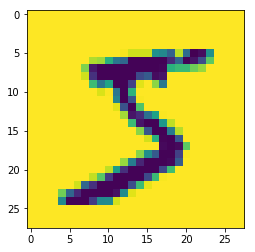

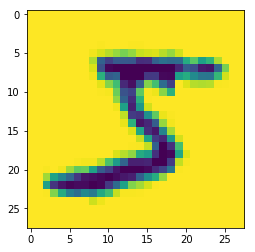

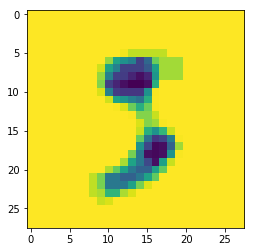

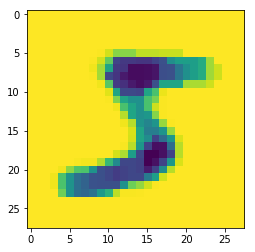

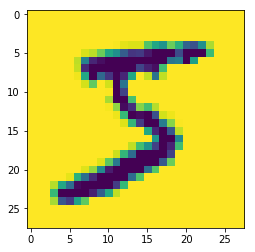

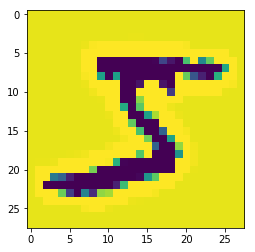

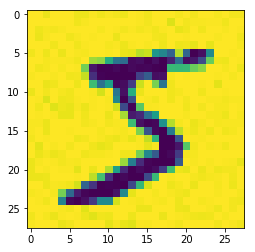

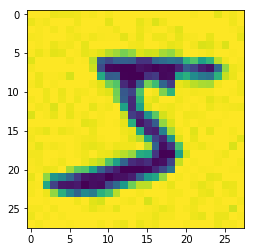

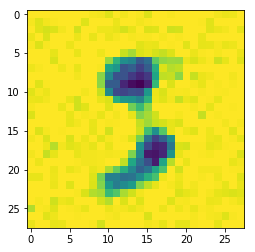

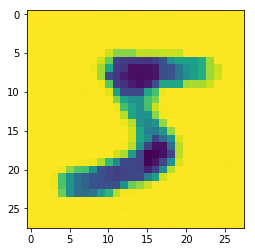

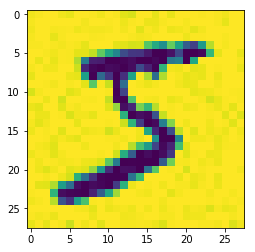

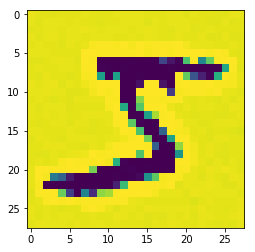

In [25]:
#test to see all different images produced for a particular image
for j,i in enumerate(image_all):
    if(j%10==0):
        i=np.squeeze(i)
        plt.imshow(i)
        plt.show()